# Traffic forecasting using graph neural networks and LSTM

Adapted from https://keras.io/examples/timeseries/timeseries_traffic_forecasting/ by [Arash Khodadadi](https://www.linkedin.com/in/arash-khodadadi-08a02490/)<br>

**Description:** This example demonstrates how to do timeseries forecasting over graphs.


# Learning objectives
- model a complex geospatial problem including temporal topology information 
- handle time-series (keras provides utility functions for creating time-series datasets)
- use an LSTM in keras
- use a graph convolution (SageConv)
- think critically about what the network is learning 

## Introduction

This example shows how to forecast traffic condition using graph neural networks and LSTM.
Specifically, we are interested in predicting the future values of the traffic speed given
a history of the traffic speed for a collection of road segments.

One popular method to
solve this problem is to consider each road segment's traffic speed as a separate
timeseries and predict the future values of each timeseries
using the past values of the same timeseries.

This method, however, ignores the dependency of the traffic speed of one road segment on
the neighboring segments. To be able to take into account the complex interactions between
the traffic speed on a collection of neighboring roads, we can define the traffic network
as a graph and consider the traffic speed as a signal on this graph. In this example,
we implement a neural network architecture which can process timeseries data over a graph.
We first show how to process the data and create a
[tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for
forecasting over graphs. Then, we implement a model which uses graph convolution and
LSTM layers to perform forecasting over a graph.

The data processing and the model architecture are inspired by this paper:

Yu, Bing, Haoteng Yin, and Zhanxing Zhu. "Spatio-temporal graph convolutional networks:
a deep learning framework for traffic forecasting." Proceedings of the 27th International
Joint Conference on Artificial Intelligence, 2018.
([github](https://github.com/VeritasYin/STGCN_IJCAI-18))

## Setup

The example uses keras 3, which is not currently installed on the server. We therefore need to upgrade keras. You may have to restart the kernel after running the following cell. 

Note that once you restart your server instance, the previous server environment is restored, which means that you need to install keras 3 again. 

In [45]:
!pip install --upgrade keras

The keras version should now show that keras 3 is used.

In [46]:
import keras
keras.__version__

'3.0.4'

In [47]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['USE_PYGEOS'] = '0'

import pandas as pd
import numpy as np
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras import ops

## Data preparation

### Data description

We use a real-world traffic speed dataset named `PeMSD7`. We use the version
collected and prepared by [Yu et al., 2018](https://arxiv.org/abs/1709.04875)
and available
[here](https://github.com/VeritasYin/STGCN_IJCAI-18/tree/master/dataset).

The data consists of two files:

- `PeMSD7_W_228.csv` contains the distances between 228
stations across the District 7 of California.
- `PeMSD7_V_228.csv` contains traffic
speed collected for those stations in the weekdays of May and June of 2012.

The full description of the dataset can be found in
[Yu et al., 2018](https://arxiv.org/abs/1709.04875).

It was sourced from https://pems.dot.ca.gov/

# EDA

In dataset folder in the github repository, there is also a csv file describing the stations. We will first have a look at that. 
It does not have a crs specified, but we can use http://projfinder.com/ to guess it. 

In [48]:
stations_df = pd.read_csv("https://github.com/VeritasYin/STGCN_IJCAI-18/raw/master/dataset/PeMSD7_M_Station_Info.csv")
stations_df

,Unnamed: 0,ID,Fwy,Dir,District,Latitude,Longitude
0,0,716939,5,S,7,34.041407,-118.218373
1,1,759700,5,S,7,34.020961,-118.195456
2,2,716925,5,N,7,33.995023,-118.144513
3,3,715930,5,N,7,33.971763,-118.122905
4,4,715938,5,N,7,34.002541,-118.150997
...,...,...,...,...,...,...,...
223,223,766337,110,S,7,33.855273,-118.284900
224,224,763272,110,S,7,33.968828,-118.281010
225,225,763532,110,N,7,33.845433,-118.285155
226,226,763522,110,N,7,33.811070,-118.287268


In [49]:
# Transform to geopandas dataframe
import geopandas as gpd
from pyproj import CRS
from shapely import Point

geometry = [Point(long,lat) for lat,long in zip(stations_df["Latitude"],stations_df["Longitude"])]

crs = CRS.from_epsg("4326")

stations_gdf = gpd.GeoDataFrame(data=stations_df, geometry=geometry, crs=crs)

stations_gdf.head()


,Unnamed: 0,ID,Fwy,Dir,District,Latitude,Longitude,geometry
0,0,716939,5,S,7,34.041407,-118.218373,POINT (-118.21837 34.04141)
1,1,759700,5,S,7,34.020961,-118.195456,POINT (-118.19546 34.02096)
2,2,716925,5,N,7,33.995023,-118.144513,POINT (-118.14451 33.99502)
3,3,715930,5,N,7,33.971763,-118.122905,POINT (-118.12291 33.97176)
4,4,715938,5,N,7,34.002541,-118.150997,POINT (-118.15100 34.00254)


In [50]:
url = "https://github.com/VeritasYin/STGCN_IJCAI-18/raw/master/dataset/PeMSD7_Full.zip"
data_dir = keras.utils.get_file(origin=url, extract=True, archive_format="zip")
data_dir = data_dir.rstrip("PeMSD7_Full.zip")

route_distances_df = pd.read_csv(
    os.path.join(data_dir, "PeMSD7_W_228.csv"), header=None
)
speeds_array_df = pd.read_csv(
    os.path.join(data_dir, "PeMSD7_V_228.csv"), header=None
)

display(route_distances_df.head())
display(speeds_array_df.head())

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
0,0.00,3165.94,8731.54,11903.45,7757.18,19878.51,18436.35,2213.47,5887.74,16132.12,...,18457.20,10725.64,9319.97,8273.62,10913.95,21561.83,10012.42,22614.08,26339.90,10012.42
1,3165.94,0.00,5625.76,8749.35,4695.51,16716.96,15274.00,1037.65,2910.29,12966.19,...,17207.37,10422.11,9441.75,8768.21,10565.72,20115.08,9915.24,21118.47,24716.98,9915.24
2,8731.54,5625.76,0.00,3280.12,1035.65,11465.75,10027.42,6659.59,2905.29,7631.76,...,17666.43,13214.26,12923.52,12756.84,13274.36,19981.55,13057.44,20827.51,23992.78,13057.44
3,11903.45,8749.35,3280.12,0.00,4315.55,8193.10,6759.32,9761.19,6171.81,4355.25,...,17482.07,14598.81,14683.19,14783.92,14610.97,19351.79,14634.38,20075.57,22897.82,14634.38
4,7757.18,4695.51,1035.65,4315.55,0.00,12500.86,11062.04,5733.14,1889.16,8667.35,...,17872.58,12942.92,12517.90,12251.20,13019.49,20308.62,12718.08,21186.77,24440.57,12718.08


,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
0,71.1,66.0,64.6,65.6,67.1,71.9,68.6,67.7,65.8,40.9,...,69.1,70.9,65.0,64.5,66.6,66.6,65.0,69.3,67.7,68.9
1,68.1,66.8,61.7,66.7,64.5,71.6,72.3,64.9,65.6,40.1,...,70.6,65.4,65.0,64.9,65.1,67.7,65.0,67.7,68.8,68.8
2,68.0,64.3,66.6,68.7,68.1,70.5,70.2,61.7,63.4,39.6,...,72.2,70.5,65.0,64.7,66.7,68.9,65.0,70.2,69.1,68.7
3,68.3,67.8,65.9,66.6,67.9,70.3,69.8,67.6,63.2,37.6,...,71.2,69.7,65.0,65.2,67.2,66.9,65.0,70.4,67.3,69.0
4,68.9,69.5,61.2,67.4,64.0,68.1,67.0,66.7,64.2,36.8,...,71.3,65.8,65.0,66.3,66.7,66.2,65.0,68.0,67.4,68.1


In [51]:
route_distances_df.shape

(228, 228)

In [52]:
speeds_array_df.shape

(12672, 228)

The route distances represents an adjacency matrix of a graph formed by the vertices (it is currently complete, i.e. there is an edge between all pairs of vertices). In order to make the training more efficient and only focus on relevant edges, very long edges are later eliminated.

The speeds array contains one line for each time point, representing the observed speeds of cars passing each station.

<Figure size 800x800 with 0 Axes>

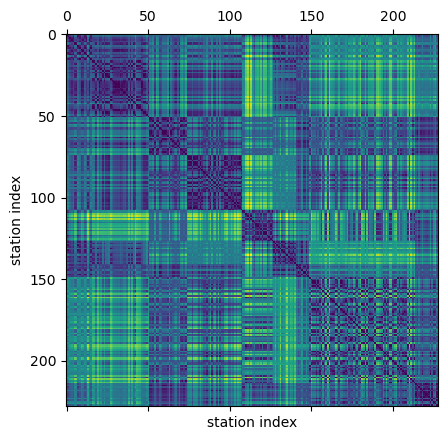

In [53]:
# adjacency matrix
plt.figure(figsize=(8, 8))
plt.matshow(route_distances_df.to_numpy())
plt.xlabel("station index")
plt.ylabel("station index")
plt.show()

In [54]:
time_index = 9
speeds = speeds_array_df.to_numpy()[time_index]

stations_gdf["speeds"] = speeds

stations_gdf.explore(column = "speeds", marker_kwds = {"radius":5})

### Loading data

In [55]:
url = "https://github.com/VeritasYin/STGCN_IJCAI-18/raw/master/dataset/PeMSD7_Full.zip"
data_dir = keras.utils.get_file(origin=url, extract=True, archive_format="zip")
data_dir = data_dir.rstrip("PeMSD7_Full.zip")

route_distances = pd.read_csv(
    os.path.join(data_dir, "PeMSD7_W_228.csv"), header=None
).to_numpy()
speeds_array = pd.read_csv(
    os.path.join(data_dir, "PeMSD7_V_228.csv"), header=None
).to_numpy()

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(228, 228)
speeds_array shape=(12672, 228)


### sub-sampling roads

To reduce the problem size and make the training faster, we will only
work with a sample of 26 roads out of the 228 roads in the dataset.
We have chosen the roads by starting from road 0, choosing the 5 closest
roads to it, and continuing this process until we get 25 roads. You can choose
any other subset of the roads. We chose the roads in this way to increase the likelihood
of having roads with correlated speed timeseries.
`sample_routes` contains the IDs of the selected roads.

In [56]:
sample_routes = [
    0,
    1,
    4,
    7,
    8,
    11,
    15,
    108,
    109,
    114,
    115,
    118,
    120,
    123,
    124,
    126,
    127,
    129,
    130,
    132,
    133,
    136,
    139,
    144,
    147,
    216,
]

route_distances = route_distances[np.ix_(sample_routes, sample_routes)]
speeds_array = speeds_array[:, sample_routes]

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(26, 26)
speeds_array shape=(12672, 26)


In [66]:
route_distances[:5]

array([[    0.  ,  3165.94,  7757.18,  2213.47,  5887.74,  4269.59,
         5371.21,  6580.34,  5271.73,  9165.09,  3153.95,  9382.32,
         4174.07,  2299.75,  7579.48,  6865.97,  3597.36,  1523.97,
         6494.29,  2908.21,  5574.54,  6485.92,  5571.97,  4665.37,
         4955.01,  6464.18],
       [ 3165.94,     0.  ,  4695.51,  1037.65,  2910.29,  1330.37,
         2391.12,  8905.88,  7658.29, 11436.41,  4646.63, 11646.7 ,
         6290.6 ,  3816.96,  9884.73,  9176.75,  1800.89,  1781.42,
         4541.54,  1270.64,  3736.09,  4525.64,  3745.69,  3184.35,
         2099.92,  8090.27],
       [ 7757.18,  4695.51,     0.  ,  5733.14,  1889.16,  3487.65,
         2391.72, 13478.02, 12273.06, 15943.74,  9145.72, 16147.63,
        10866.66,  8409.3 , 14431.76, 13738.55,  4497.44,  6474.32,
         3708.01,  4953.96,  3889.46,  3690.  ,  3910.8 ,  4494.9 ,
         2845.22, 12385.08],
       [ 2213.47,  1037.65,  5733.14,     0.  ,  3937.82,  2329.5 ,
         3416.16,  7913.43,  

### Data visualization

Here are the timeseries of the traffic speed for two of the routes:

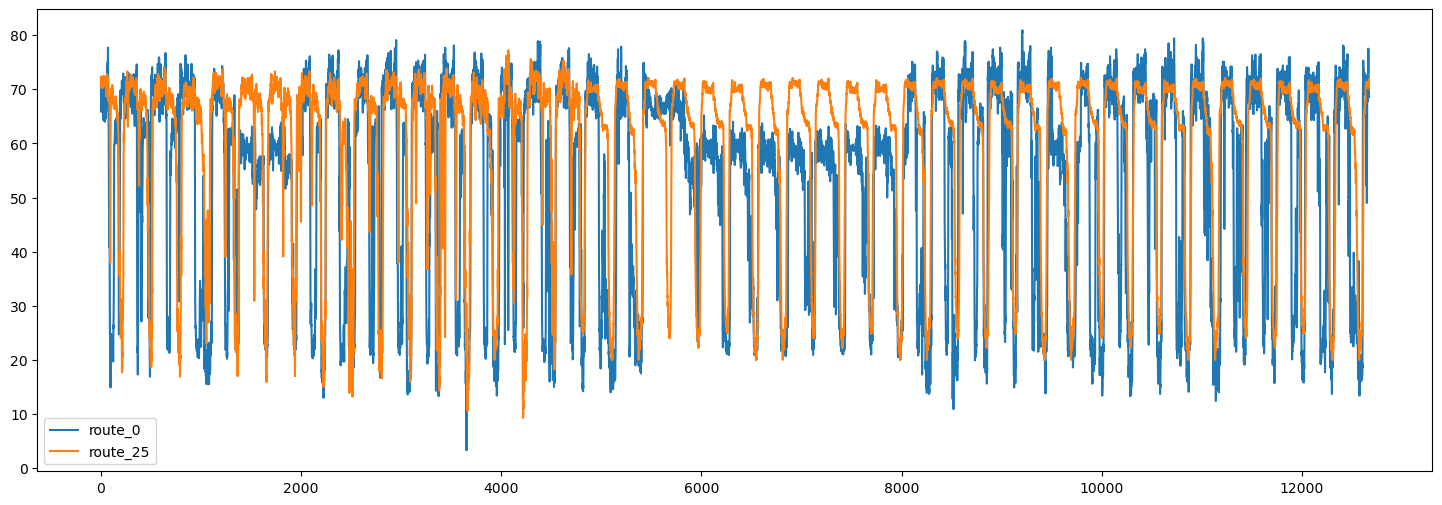

In [67]:
plt.figure(figsize=(18, 6))
plt.plot(speeds_array[:, [0, -1]])
plt.legend(["route_0", f"route_{speeds_array.shape[1]-1}"])

We can also visualize the correlation between the timeseries in different routes.

Text(0.5, 1.0, 'Correlation of Speeds')

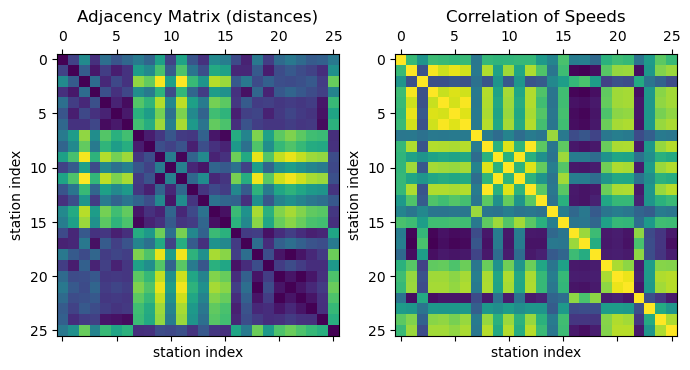

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].matshow(route_distances)
ax[0].set_xlabel("station index")
ax[0].set_ylabel("station index")
ax[0].set_title("Adjacency Matrix (distances)")

ax[1].matshow(np.corrcoef(speeds_array.T))
ax[1].set_xlabel("station index")
ax[1].set_ylabel("station index")
ax[1].set_title("Correlation of Speeds")

Using this correlation heatmap, we can see that for example the speed in
routes 4, 5, 6 are highly correlated.

**Now, how do we formulate a machine learning problem from this information?**

# Modeling


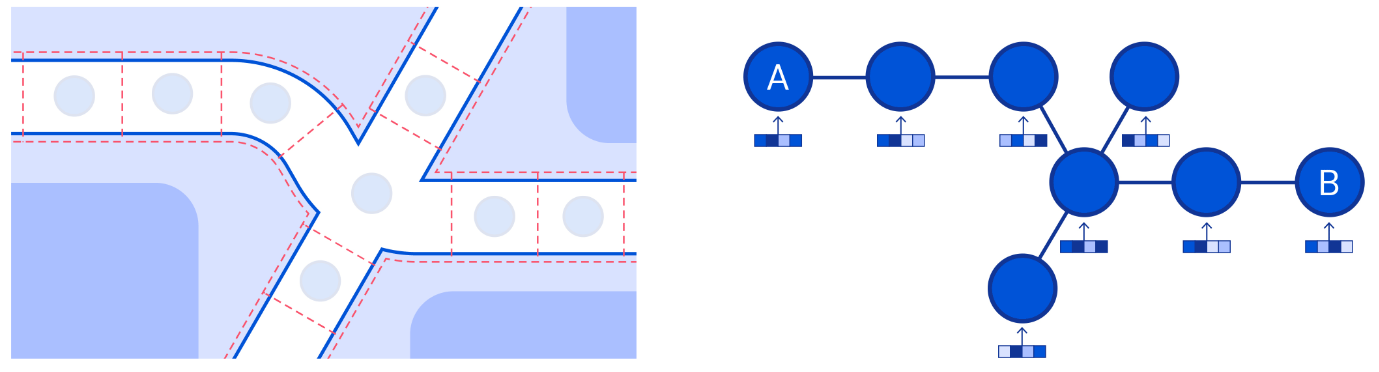

(source: https://arxiv.org/abs/2108.11482)

The stations are vertices in a graph, the distances between them can be modeled as edge weights. In order to reduce the number of edges, we can set a threshold on the distance and discard long ones.

We have one such graph for each time point. Note that the paper denotes full graphs for a time point $t$ as $v_t$, i.e. the $v$ does **not** represent a vertex.

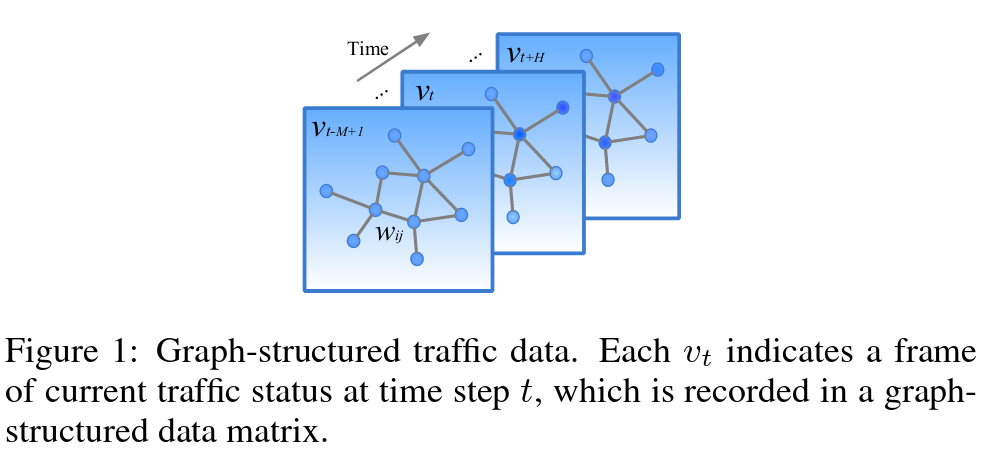

Given the traffic situation $v$ for time points ${t-M+1}$ to $t$, we want to predict the traffic situations $v_{t+1}$ to $v_{t+H}$ in the future. The variable $H$ refers to the horizon and how far we want to look into the future.

## Feature extraction using a graph convolution (SageConv)
https://arxiv.org/pdf/1706.02216.pdf

This is actually quite similar to PointNet. We compute vertex features (in this case not the 3D locations but the observed speeds at that station). These are processed independently, then we aggregate the results from the neighbours for each vertex. 

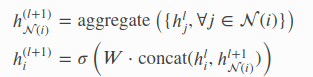


### Key differences to PointNet

- **PointNet** deals with unstructured point cloud data, where each point is an individual entity with its features (e.g., position, color). From that we compute a neighbourhood by considering the radius around a point. **SageConv (GraphSAGE)** operates on graph data, where entities (nodes) are connected by edges, implying relationships or interactions. Each node has its features, and the structure of the graph conveys additional information.

- Feature Aggregation: **PointNet** independently processes each point to extract features and then aggregates these features globally, without considering local neighborhoods or explicit relationships between points. **SageConv** explicitly samples a subset of neighbors for each node and aggregates their features, along with the target node’s features, to learn a representation. This process considers both the features of the nodes and their connectivity, enabling the model to capture the local structural information within the graph.

- In this case, we do not downsample the graph in any way, but compute features for every vertex.

## Time-series handling

Here, we can use an RNN, specifically an LSTM, which is chainged and predicts the next time-steps, while keeping an internal state of the situation.

## Combining the two
The graph network is used to extract features while considering the neighbourhood of each station. Then these are fed into the LSTM. So we simply stack both on top of each other.
A final fully-connected layer is added as a head for predicting the final traffic situation.


# Implementation
### Splitting and normalizing data

Next, we split the speed values array into train/validation/test sets,
and normalize the resulting arrays:

In [69]:
train_size, val_size = 0.5, 0.2


def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array


train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (6336, 26)
validation set size: (2534, 26)
test set size: (3802, 26)


### Creating TensorFlow Datasets

Next, we create the datasets for our forecasting problem. The forecasting problem
can be stated as follows: given a sequence of the
road speed values at times `t+1, t+2, ..., t+T`, we want to predict the future values of
the roads speed for times `t+T+1, ..., t+T+h`. So for each time `t` the inputs to our
model are `T` vectors each of size `N` and the targets are `h` vectors each of size `N`,
where `N` is the number of roads.

We use the Keras built-in function
`keras.utils.timeseries_dataset_from_array`.
The function `create_tf_dataset()` below takes as input a `numpy.ndarray` and returns a
`tf.data.Dataset`. In this function `input_sequence_length=T` and `forecast_horizon=h`.

The argument `multi_horizon` needs more explanation. Assume `forecast_horizon=3`.
If `multi_horizon=True` then the model will make a forecast for time steps
`t+T+1, t+T+2, t+T+3`. So the target will have shape `(T,3)`. But if
`multi_horizon=False`, the model will make a forecast only for time step `t+T+3` and
so the target will have shape `(T, 1)`.

You may notice that the input tensor in each batch has shape
`(batch_size, input_sequence_length, num_routes, 1)`. The last dimension is added to
make the model more general: at each time step, the input features for each raod may
contain multiple timeseries. For instance, one might want to use temperature timeseries
in addition to historical values of the speed as input features. In this example,
however, the last dimension of the input is always 1.

We use the last 12 values of the speed in each road to forecast the speed for 3 time
steps ahead:

In [ ]:
batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = keras.utils.timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = keras.utils.timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)


### Roads Graph

As mentioned before, we assume that the road segments form a graph.
The `PeMSD7` dataset has the road segments distance. The next step
is to create the graph adjacency matrix from these distances. Following
[Yu et al., 2018](https://arxiv.org/abs/1709.04875) (equation 10) we assume there
is an edge between two nodes in the graph if the distance between the corresponding roads
is less than a threshold.

In [ ]:

def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.

    Args:
        route_distances: np.ndarray of shape `(num_routes, num_routes)`. Entry `i,j` of this array is the
            distance between roads `i,j`.
        sigma2: Determines the width of the Gaussian kernel applied to the square distances matrix.
        epsilon: A threshold specifying if there is an edge between two nodes. Specifically, `A[i,j]=1`
            if `np.exp(-w2[i,j] / sigma2) >= epsilon` and `A[i,j]=0` otherwise, where `A` is the adjacency
            matrix and `w2=route_distances * route_distances`

    Returns:
        A boolean graph adjacency matrix.
    """
    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask


The function `compute_adjacency_matrix()` returns a boolean adjacency matrix
where 1 means there is an edge between two nodes. We use the following class
to store the information about the graph.

In [ ]:

class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = 0.5
adjacency_matrix = compute_adjacency_matrix(route_distances, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

## Network architecture

Our model for forecasting over the graph consists of a graph convolution
layer and a LSTM layer.

### Graph convolution layer

Our implementation of the graph convolution layer resembles the implementation
in [this Keras example](https://keras.io/examples/graph/gnn_citations/). Note that
in that example input to the layer is a 2D tensor of shape `(num_nodes,in_feat)`
but in our example the input to the layer is a 4D tensor of shape
`(num_nodes, batch_size, input_seq_length, in_feat)`. The graph convolution layer
performs the following steps:

- The nodes' representations are computed in `self.compute_nodes_representation()`
by multiplying the input features by `self.weight`
- The aggregated neighbors' messages are computed in `self.compute_aggregated_messages()`
by first aggregating the neighbors' representations and then multiplying the results by
`self.weight`
- The final output of the layer is computed in `self.update()` by combining the nodes
representations and the neighbors' aggregated messages

In [ ]:

class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = self.add_weight(
            initializer=keras.initializers.GlorotUniform(),
            shape=(in_feat, out_feat),
            dtype="float32",
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return ops.matmul(features, self.weight)

    def compute_aggregated_messages(self, features):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return ops.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation, aggregated_messages):
        if self.combination_type == "concat":
            h = ops.concatenate([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")
        return self.activation(h)

    def call(self, features):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)


### LSTM plus graph convolution

By applying the graph convolution layer to the input tensor, we get another tensor
containing the nodes' representations over time (another 4D tensor). For each time
step, a node's representation is informed by the information from its neighbors.

To make good forecasts, however, we need not only information from the neighbors
but also we need to process the information over time. To this end, we can pass each
node's tensor through a recurrent layer. The `LSTMGC` layer below, first applies
a graph convolution layer to the inputs and then passes the results through a
`LSTM` layer.

In [ ]:

class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = ops.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = ops.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = ops.reshape(
            gcn_out, (batch_size * num_nodes, input_seq_len, out_feat)
        )
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = ops.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return ops.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)


## Model training

In [ ]:
in_feat = 1
batch_size = 64
epochs = 20
input_sequence_length = 12
#forecast_horizon = 3
multi_horizon = False
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)

In [ ]:

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

## Making forecasts on test set

Now we can use the trained model to make forecasts for the test set. Below, we
compute the MAE of the model and compare it to the MAE of naive forecasts.
The naive forecasts are the last value of the speed for each node.

In [ ]:
x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.legend(["actual", "forecast"])

naive_mse, model_mse = (
    np.square(x_test[:, -1, :, 0] - y[:, 0, :]).mean(),
    np.square(y_pred[:, 0, :] - y[:, 0, :]).mean(),
)
print(f"naive MAE: {naive_mse}, model MAE: {model_mse}")

Of course, the goal here is to demonstrate the method,
not to achieve the best performance. To improve the
model's accuracy, all model hyperparameters should be tuned carefully. In addition,
several of the `LSTMGC` blocks can be stacked to increase the representation power
of the model.

# Exercises

**Question 1**: How far do we predict into the future (in actual minutes)?

**Question 2**: What information is available to the network for predicting the traffic speeds in the future?

**Question 3**: The predictions in the plot above show some slight offset compared to the ground truth data. Why? (You can increase the forecast horizon in order to make the effect more pronounced.)

**Question 4**: Relating to question 2 and 3, what other information might also be relevant? 

**Question 5**: How could the additional information be integrated? Which dimension would then change?

**Question 6**: If we would want to predict the traffic speeds for a different area, what would we need to do?
